In [110]:
%load_ext autoreload
%autoreload 2

from rBergomi import roughBergomi, bsImpVol
import matplotlib.pyplot as plt
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### The effect of H

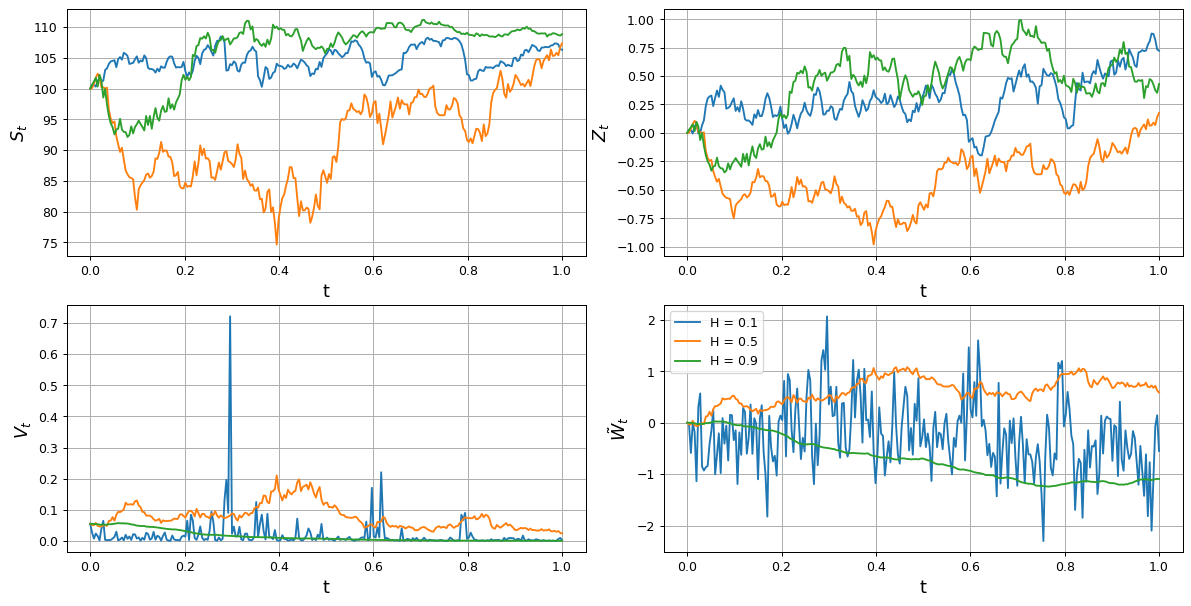

In [46]:
h = np.array([0.1, 0.5, 0.9])
s, z, v, volt = {}, {}, {}, {}

for i, H in zip(range(3), h):
    model = roughBergomi(n_paths = 1, n_steps = 253)
    volterra, W, dW = model.simPaths(H = 0.1+i*0.4, rho = -0.8)
    V = model.simV(volterra, eta = 2)
    S = model.simS(V, dW, spot = 100.0)
    s['H={}'.format(H)] = S
    volt['H={}'.format(H)] = volterra
    z['H={}'.format(H)] = W
    v['H={}'.format(H)] = V

t = np.linspace(0, model.T, model.s + 1)

fig, ax = plt.subplots(2, 2, squeeze=False, dpi=90)
fig.set_size_inches(16, 8)
fig.subplots_adjust(wspace=0.15)

for H in h:
    ax[0,0].plot(t, s['H={}'.format(H)].T, label = 'H = {}'.format(H))
ax[0,0].set_ylabel(r'$ S_t$', fontsize=14)
ax[0,0].set_xlabel('t', fontsize=14)

for H in h:
    ax[0,1].plot(t, z['H={}'.format(H)].T,  label = 'H = {}'.format(H))
ax[0,1].set_ylabel(r'$Z_t$', fontsize=14)
ax[0,1].set_xlabel('t', fontsize=14)

for H in h:
    ax[1,0].plot(t, v['H={}'.format(H)].T,  label = 'H = {}'.format(H))
ax[1,0].set_ylabel(r'$V_t$', fontsize=14)
ax[1,0].set_xlabel('t', fontsize=14)

for H in h:
    ax[1,1].plot(t, volt['H={}'.format(H)].T,  label = 'H = {}'.format(H))
ax[1,1].set_ylabel(r'$\tilde{W}_t$', fontsize=14)
ax[1,1].set_xlabel('t', fontsize=14)

ax[0,0].grid(True)
ax[0,1].grid(True)
ax[1,0].grid(True)
ax[1,1].grid(True)

plt.legend(loc='upper left')

plt.show()

### Implied volatility of European call options in the rough Bergomi model

In [54]:
k = np.arange(-0.1, 0.11, 0.01)
K = np.exp(k)
rho = [-0.9, 0]
T = [0.083, 0.5, 1]
H = [0.1] #[0.1, 0.25, 0.5]
IV = {}

for ttm in T:
    for r in rho:

        n = round(253/ttm)

        model = roughBergomi(n_paths = 100000, n_steps = n, T = ttm)
        volterra, W, dW = model.simPaths(H = 0.1, rho = r)
        V = model.simV(volterra, eta = 1.9)
        S = model.simS(V, dW, spot = 1.0)

        impVol, p = [], []
        for strike in K:

            price = model.callPrice(S, strike = strike)
            p.append(price)

            try:
                
                iv = bsImpVol(price, 1.0, strike, model.T)

            except:

                iv = np.nan

            impVol.append(iv)

        IV['impVol_{}_{}'.format(ttm, r)] = impVol

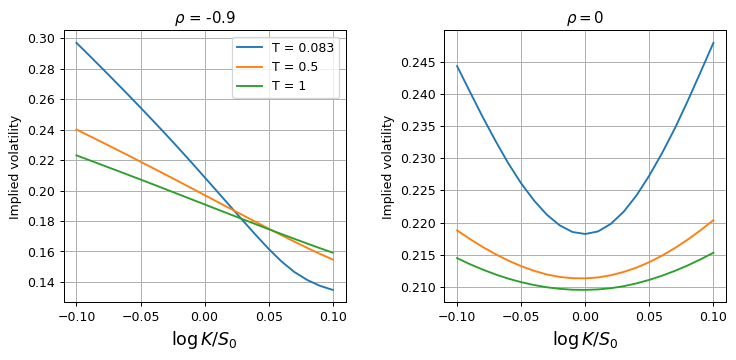

In [55]:
fig, ax = plt.subplots(1, 2, squeeze=False, dpi=90)
fig.set_size_inches(9.5, 4)
fig.subplots_adjust(wspace=0.35)

for ttm in T:   
    ax[0,0].plot(k, IV['impVol_{}_-0.9'.format(ttm)], label = 'T = {}'.format(ttm))
ax[0,0].set_ylabel('Implied volatility', fontsize=10)
ax[0,0].set_xlabel(r'$\log{K/S_0}$', fontsize=14)
ax[0,0].set_title(r'$\rho$ = -0.9')
ax[0,0].legend()
ax[0,0].grid(True)

for ttm in T:   
    ax[0,1].plot(k, IV['impVol_{}_0'.format(ttm)], label = 'T = {}'.format(ttm))
ax[0,1].set_ylabel('Implied volatility', fontsize=10)
ax[0,1].set_xlabel(r'$\log{K/S_0}$', fontsize=14)
ax[0,1].set_title(r'$\rho = 0$')
ax[0,1].grid(True)

plt.show()

### Volterra and variance process

In [56]:
xi = 0.235**2
spot = 100

model = roughBergomi(n_paths = 100000, n_steps = 253)
volterra, W, dW = model.simPaths()
V = model.simV(volterra, xi = xi)
S = model.simS(V, dW, spot = spot)
t = np.linspace(0, model.T, model.s + 1)

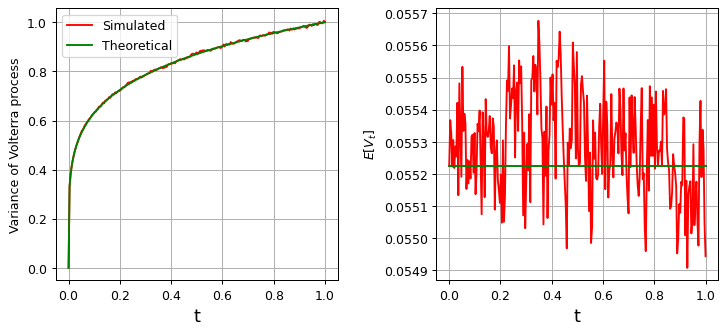

In [58]:
fig, ax = plt.subplots(1, 2, squeeze=False, dpi=90)
fig.set_size_inches(9.5, 4)
fig.subplots_adjust(wspace=0.35)
ax[0,0].plot(t, np.var(volterra, axis=0), 'r', label='Simulated')
ax[0,0].plot(t, t**(2*(model.H - 0.5) + 1), 'g', label='Theoretical')
ax[0,0].set_ylabel('Variance of Volterra process', fontsize=10)
ax[0,0].set_xlabel('t', fontsize=14)
ax[0,1].plot(t, np.mean(V, axis=0), 'r', label='Simulated')
ax[0,1].plot(t, xi * np.ones_like(t), 'g', label='Theoretical')
ax[0,1].set_ylabel(r'$E[ V_t ]$', fontsize=10)
ax[0,1].set_xlabel('t', fontsize=14)
ax[0,0].grid(True)
ax[0,1].grid(True)
ax[0,0].legend()
plt.show()

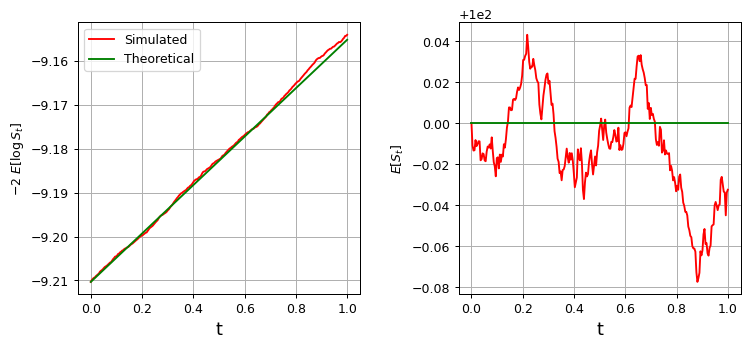

In [61]:
fig, ax = plt.subplots(1, 2, squeeze=False, dpi=90)
fig.set_size_inches(9.5, 4)
fig.subplots_adjust(wspace=0.35)
ax[0,0].grid(True)
ax[0,1].grid(True)
ax[0,0].plot(t, -2*np.mean(np.log(S), axis=0), 'r', label='Simulated')
ax[0,0].plot(t, xi * t - 2* np.log(spot), 'g', label='Theoretical')
ax[0,0].set_ylabel(r'$-2\ E[ \log S_t ]$', fontsize=10)
ax[0,0].set_xlabel('t', fontsize=14)
ax[0,1].plot(t, np.mean(S, axis=0), 'r', label='Simulated')
ax[0,1].plot(t, np.repeat(spot, t.shape[0]), 'g', label='Theoretical')
ax[0,1].set_ylabel(r'$E[ S_t ]$', fontsize=10)
ax[0,1].set_xlabel('t', fontsize=14)
ax[0,0].legend()
plt.show()

### Paths in the rough Bergomi model

In [63]:
model = roughBergomi(n_paths = 3, n_steps = 253)
volterra, W, dW = model.simPaths(rho = -0.8)
V = model.simV(volterra)
S = model.simS(V, dW, spot = 100)

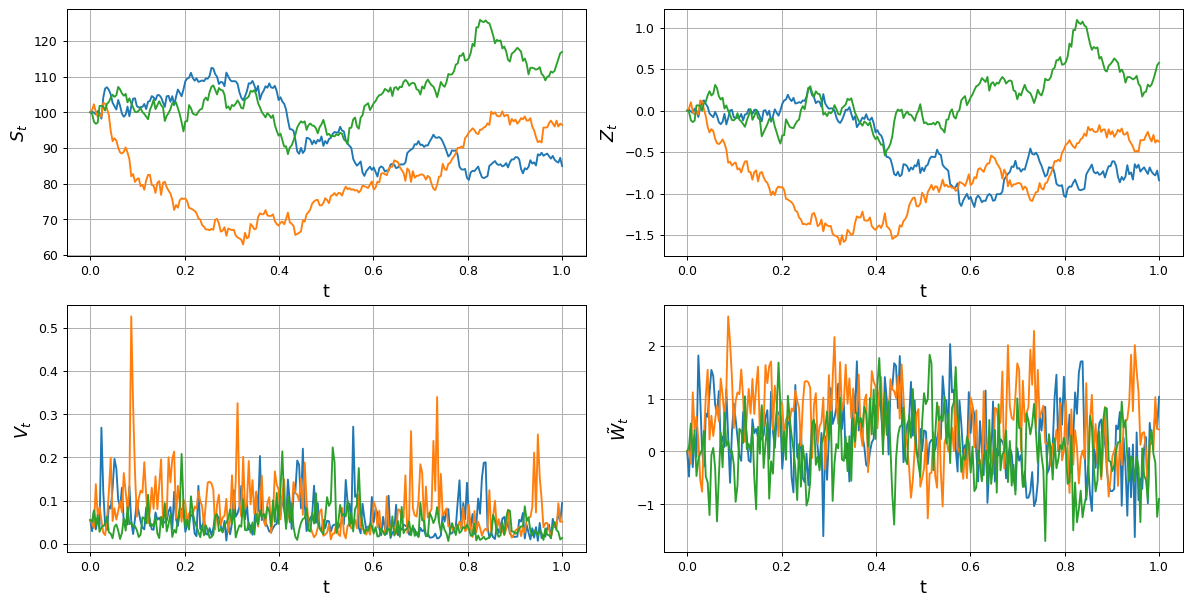

In [64]:
fig, ax = plt.subplots(2, 2, squeeze=False, dpi=90)
fig.set_size_inches(16, 8)
fig.subplots_adjust(wspace=0.15)

ax[0,0].plot(t, S.T)
ax[0,0].set_ylabel(r'$ S_t$', fontsize=14)
ax[0,0].set_xlabel('t', fontsize=14)

ax[0,1].plot(t, W.T)
ax[0,1].set_ylabel(r'$Z_t$', fontsize=14)
ax[0,1].set_xlabel('t', fontsize=14)

ax[0,0].grid(True)
ax[0,1].grid(True)

ax[1,0].plot(t, V.T)
ax[1,0].set_ylabel(r'$V_t$', fontsize=14)
ax[1,0].set_xlabel('t', fontsize=14)
ax[1,1].plot(t, volterra.T)
ax[1,1].set_ylabel(r'$\tilde{W}_t$', fontsize=14)
ax[1,1].set_xlabel('t', fontsize=14)
ax[1,0].grid(True)
ax[1,1].grid(True)

plt.show()

### Monte Carlo precision

In [70]:
paths = [1000, 1000000]
spot, price, delta = {}, {}, {}

for n in paths:
    print('Number of paths: ', n)
    model = roughBergomi(n_paths=n)
    volterra, W, dW = model.simPaths()
    spot['spots_{}'.format(n)], price['prices_{}'.format(n)], delta['deltas{}'.format(n)] = model.testSet(dW, volterra, spot=100.0, strike=100.0, upper=35, lower=165, n=100)

Number of paths:  1000


Simulating test set:   0%|          | 0/100 [00:00<?, ?it/s]

Number of paths:  1000000


Simulating test set:   0%|          | 0/100 [00:00<?, ?it/s]

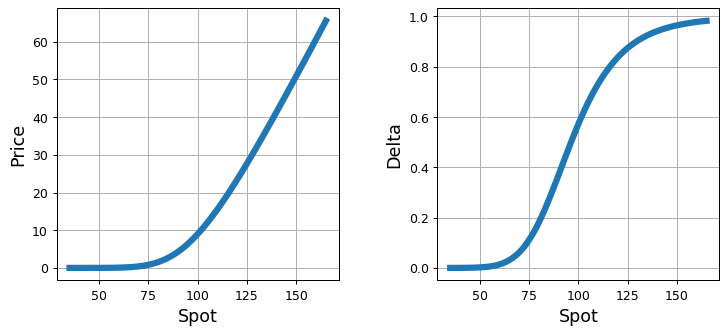

In [71]:
fig, ax = plt.subplots(1, 2, squeeze=False, dpi=90)
fig.set_size_inches(9.5, 4)
fig.subplots_adjust(wspace=0.35)
ax[0,0].grid(True)
ax[0,1].grid(True)
ax[0,0].plot(spot['spots_1000000'], price['prices_1000000'], linewidth=5)
ax[0,0].set_ylabel('Price', fontsize=14)
ax[0,0].set_xlabel('Spot', fontsize=14)
ax[0,1].plot(spot['spots_1000000'], delta['deltas1000000'], linewidth=5)
ax[0,1].set_ylabel('Delta', fontsize=14)
ax[0,1].set_xlabel('Spot', fontsize=14)
plt.show()

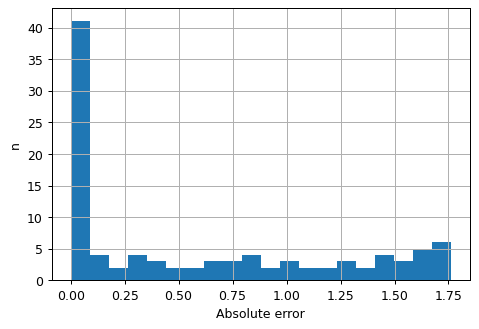

In [76]:
res = abs(price['prices_1000000'] - price['prices_1000'])
fig, ax=plt.subplots(dpi=90)
plt.hist(res, bins=20)
plt.ylabel('n')
plt.xlabel('Absolute error')
plt.grid(True)
plt.show()

### Exocit derivatives

In [82]:
model = roughBergomi(n_paths=100000)
volterra, W, dW = model.simPaths()

In [92]:
c_spots, c_prices, c_deltas = model.testSet(dW, volterra, lower=0.01, upper=0.15, n=100, payoff='Cliquet', deriv=1)
a_spots, a_prices, a_deltas = model.testSet(dW, volterra, upper=35, lower=165, spot=100, strike=100, n=100, payoff='Asian')

Simulating test set:   0%|          | 0/100 [00:00<?, ?it/s]

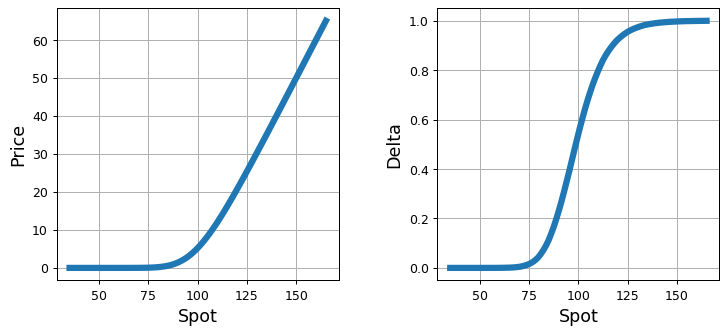

In [84]:
fig, ax = plt.subplots(1, 2, squeeze=False, dpi=90)
fig.set_size_inches(9.5, 4)
fig.subplots_adjust(wspace=0.35)
ax[0,0].grid(True)
ax[0,1].grid(True)
ax[0,0].plot(a_spots, a_prices, linewidth=5)
ax[0,0].set_ylabel('Price', fontsize=14)
ax[0,0].set_xlabel('Spot', fontsize=14)
ax[0,1].plot(a_spots, a_deltas, linewidth=5)
ax[0,1].set_ylabel('Delta', fontsize=14)
ax[0,1].set_xlabel('Spot', fontsize=14)
plt.show()

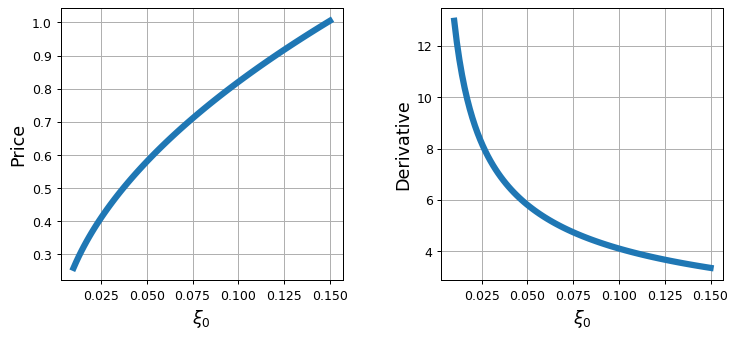

In [93]:
fig, ax = plt.subplots(1, 2, squeeze=False, dpi=90)
fig.set_size_inches(9.5, 4)
fig.subplots_adjust(wspace=0.35)
ax[0,0].grid(True)
ax[0,1].grid(True)
ax[0,0].plot(c_spots, c_prices, linewidth=5)
ax[0,0].set_ylabel('Price', fontsize=14)
ax[0,0].set_xlabel(r'$\xi_0$', fontsize=14)
ax[0,1].plot(c_spots, c_deltas, linewidth=5)
ax[0,1].set_ylabel('Derivative', fontsize=14)
ax[0,1].set_xlabel(r'$\xi_0$', fontsize=14)
plt.show()

### ADD precision

In [111]:
model = roughBergomi(n_paths=10000)
volterra, W, dW = model.simPaths()
V = model.simV(volterra)
S = model.simS(V, dW, spot = 1.0)
spots, prices, aad_deltas = model.trainingSet(dW, volterra, payoff='European')
terminal_S = S[:,model.s]
theoretical_deltas = np.where(terminal_S >= 1.0, terminal_S/1.0, 0)

Simulating training set:   0%|          | 0/10000 [00:00<?, ?it/s]

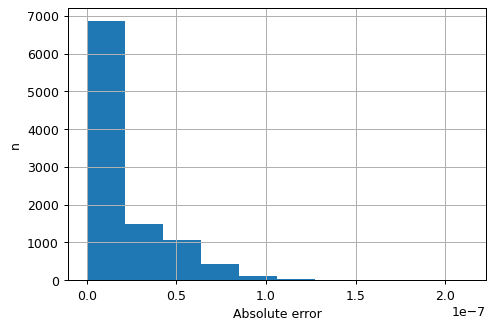

In [113]:
res = abs(aad_deltas - theoretical_deltas.reshape(-1,1))
fig, ax=plt.subplots(dpi=90)
plt.hist(res)
plt.xlabel('Absolute error')
plt.ylabel('n')
plt.grid(True)
plt.show()